# The backward Process

In [ ]:
import math
import torch
import torchvision
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import Image as IPImage
from tqdm import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
import math
from torch.optim import Adam


In [2]:
PATH = "/home/azureuser/Diffusion/"
DATA_PATH = PATH + "/data/images"
OUTPUT_PATH = PATH + "/data/reshaped"

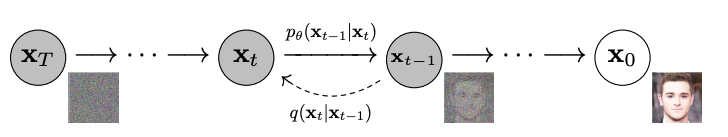

In [3]:
IPImage(filename= PATH + "display_images/Screenshot 2025-04-29 at 15.41.33.png") 

If we knew the conditional distribution p(xt-1|xt), we could sample from it by sampling xt and then applying the inverse of the diffusion process. However, we don't know this distribution, it's intractable, so we need to approximate it. We can do this by training a neural network to predict xt-1 given xt.

# Creating the dataset

I have extracted a dataset of 10000 planes, to save time and memory I have converted them to (64,64). Diffusion requires the input and the output image size to be the same, therefore it makes sense to train everything on images of the same size and begin the sampling (more on this shortly) from a (64,64) image too. 

In [4]:
TARGET_SIZE = (64,64)
transform = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor(),
])

def process_images():
    # Get all image files
    image_files = [f for f in os.listdir(DATA_PATH) if f.endswith(('.png', '.jpg', '.jpeg'))]
    
    print(f"Found {len(image_files)} images to process")
    
    # Process each image
    for img_file in tqdm(image_files):
        try:
            # Load image
            img_path = os.path.join(DATA_PATH, img_file)
            img = Image.open(img_path).convert('RGB')
            
            # Resize image
            img_resized = transforms.Resize(TARGET_SIZE)(img)
            
            # Save resized image
            save_path = os.path.join(OUTPUT_PATH, img_file)
            img_resized.save(save_path)
            
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
    
    print(f"Processed images saved to {OUTPUT_PATH}")


#process_images()


Found 10000 images to process


100%|██████████| 10000/10000 [01:57<00:00, 84.81it/s]

Processed images saved to /home/azureuser/Diffusion//data/reshaped


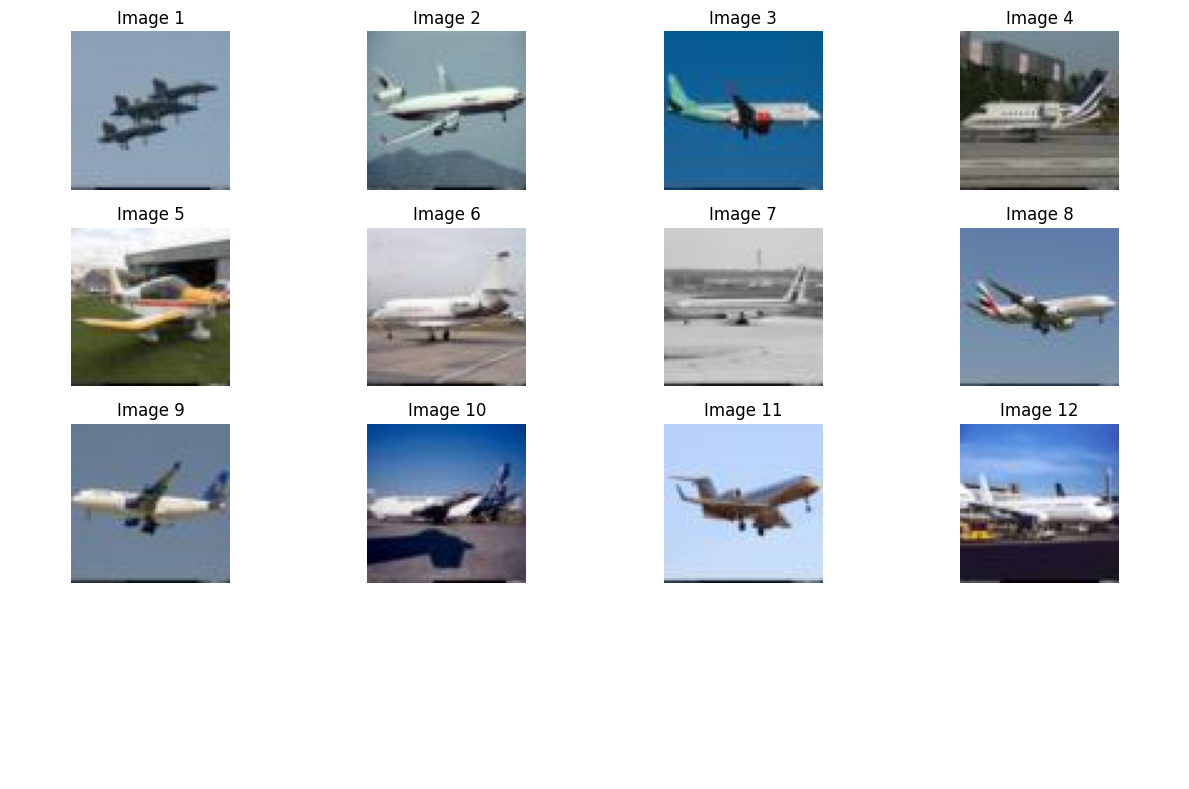

In [5]:
def display_sample_images(image_dir, num_images=16):
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    if len(image_files) > num_images:
        sampled_files = np.random.choice(image_files, num_images, replace=False)
    else:
        sampled_files = image_files
        print(f"Only {len(image_files)} images found. Showing all.")
    
    grid_size = int(np.ceil(np.sqrt(len(sampled_files))))
    
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 8))
    axes = axes.flatten()
    
    for i, img_file in enumerate(sampled_files):
        img_path = os.path.join(image_dir, img_file)
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Image {i+1}")
        axes[i].axis('off')
    
    for i in range(len(sampled_files), grid_size*grid_size):
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()

display_sample_images(OUTPUT_PATH, num_images=12)

# Model Inputs

The inputs to our model are more and more noisy images, at various timestamps. Therefore, we have pairs of images and timestamps. 

In [6]:
# Could use linear beta schedule
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

#But it seems that Cosine is more effective
def cosine_beta_schedule(T, s=0.008):
    """Creates the Cosine schedule from Nichol & Dhariwal (2021)
    ^^ this paper proves that its better than a linear schedule .
    [https://arxiv.org/pdf/2102.09672]
    """
    steps = torch.arange(T + 1, dtype=torch.float32) #1D tensor
    alphas_cumprod = torch.cos(
        (steps / T + s) / (1 + s) * math.pi * 0.5
    ) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return betas.clamp(1e-8, 0.999) 

In [7]:
def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [8]:
def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

In [9]:
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [10]:
def load_transformed_dataset():
    """
    Load the reshaped dataset with appropriate transformations for diffusion model training.
    
    Returns:
        torch.utils.data.Dataset: Dataset of transformed images
    """
    data_transforms = [
        # We don't need to resize again since images are already resized to TARGET_SIZE
        transforms.RandomHorizontalFlip(),  # Data augmentation
        transforms.ToTensor(),  # Convert to tensor and scale to [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scale to [-1, 1] range for diffusion model
    ]
    data_transform = transforms.Compose(data_transforms)
    
    class ImageFolderDataset(torch.utils.data.Dataset):
        def __init__(self, folder_path, transform=None):
            self.folder_path = folder_path
            self.transform = transform
            self.image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
            
        def __len__(self):
            return len(self.image_files)
        
        def __getitem__(self, idx):
            img_path = os.path.join(self.folder_path, self.image_files[idx])
            image = Image.open(img_path).convert("RGB")
            
            if self.transform:
                image = self.transform(image)
                
            return image
    
    # Create the dataset using the reshaped images
    dataset = ImageFolderDataset(folder_path=OUTPUT_PATH, transform=data_transform)
    
    return dataset

In [11]:
# Load the dataset
dataset = load_transformed_dataset()

# Create a DataLoader
batch_size = 32
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Example of using the data loader
for batch in dataloader:
    print(f"Batch shape: {batch.shape}")
    print(f"Value range: [{batch.min().item()}, {batch.max().item()}]")
    break

Batch shape: torch.Size([32, 3, 64, 64])
Value range: [-1.0, 1.0]


In [12]:
len(dataset)

10000

In [13]:
dataset[0].shape

torch.Size([3, 64, 64])

In [14]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :] 
    plt.imshow(reverse_transforms(image))

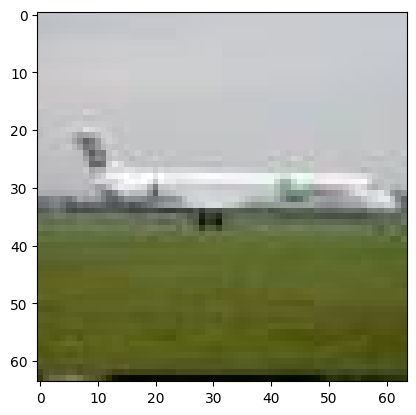

In [15]:
show_tensor_image(dataset[42])

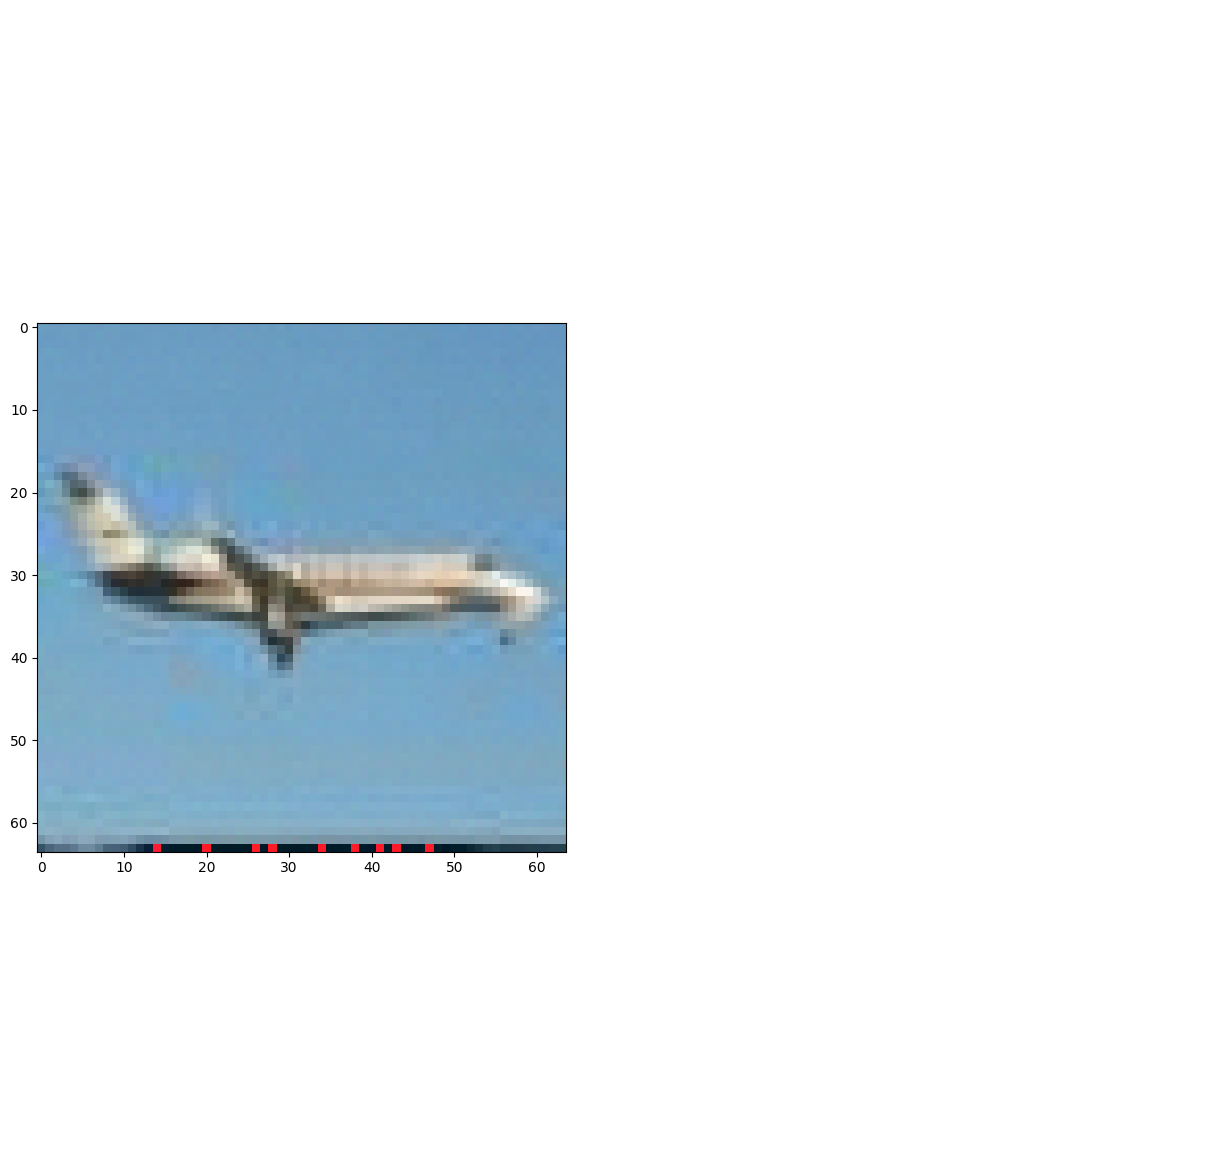

In [24]:
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 1
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img)

In [17]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

In [ ]:
# Remember sample means that we are 'creating' an image from a noisier image. 
# We are inputting an image at time t and getting an image at time t-1.
@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.

    1. It takes the image with noise from timestep t
    2. Uses the neural network to predict what noise was added at that step
    3. Removes that predicted noise (with appropriate scaling factors)
    4. Adds a smaller amount of new noise if not at t=0
    5. Returns the slightly denoised image
    """
    # Get the beta (and alpha) value for the current timestep
    # This is the noise schedule, defined in hyperparameters.
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        # Sample from the posterior distribution
        # Basically, we add noise to the model mean.
        # Prevents the generation from being too deterministic.
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 


# Here we are reaptedly sampling from the model to create a new image.
# We start with a random noise image and then iteratively denoise it.
# This is basically a repeated call of sample_timestep until the process is over. 
@torch.no_grad()
def sample_plot_image():
    """
    This is the core of the diffusion process, it implements the backward process from to create
    a new image from randomly generated noise. 
    """
    # Setting image size (same size in as comes out)
    img_size = IMG_SIZE
    # Creates tensor of random noise [1,3,64,64] 
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,5))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]: #[::-1] to go backwards, there this is from T-1 > 0
        t = torch.full((1,), i, device=device, dtype=torch.long) #creates a tensor of the current timestep
        img = sample_timestep(img, t) # passes the image and the current timestep to the model for denoising
        img = torch.clamp(img, -1.0, 1.0) # Edit: This is to maintain the natural range of the distribution

        # Displaying the image at regular intervals
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            show_tensor_image(img.detach().cpu())
    plt.show()   

In [ ]:
def get_loss(model, x_0, t):
    # adds noise to the clean image according to the schedule at time t.
    x_noisy, noise = forward_diffusion_sample(x_0, t, device) #therefore we have the noise added and the noisy image
    # Have the model predict that noise
    noise_pred = model(x_noisy, t)
    # Calculate the loss between the predicted noise and the actual noise using L1
    return F.l1_loss(noise, noise_pred)

Epoch 0 | step 000 Loss: 0.09492494910955429 


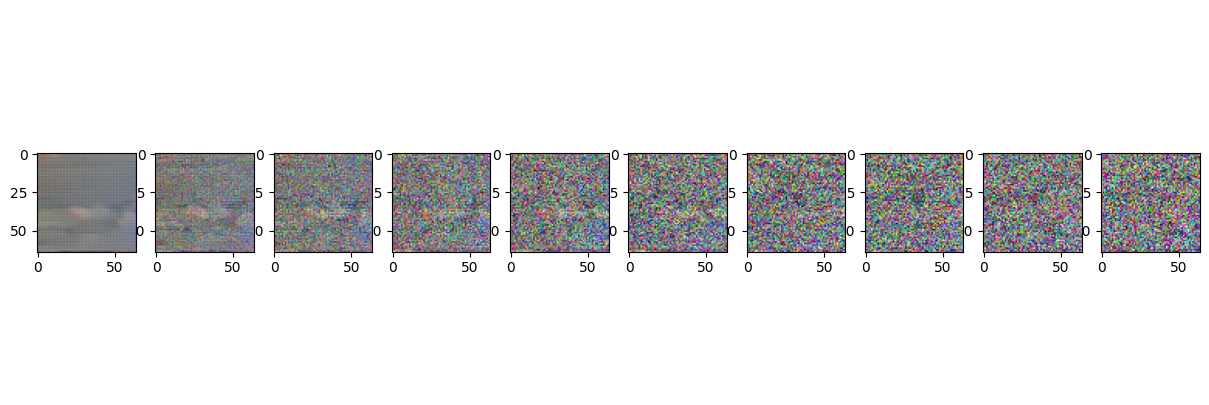

Epoch 10 | step 000 Loss: 0.09418652951717377 


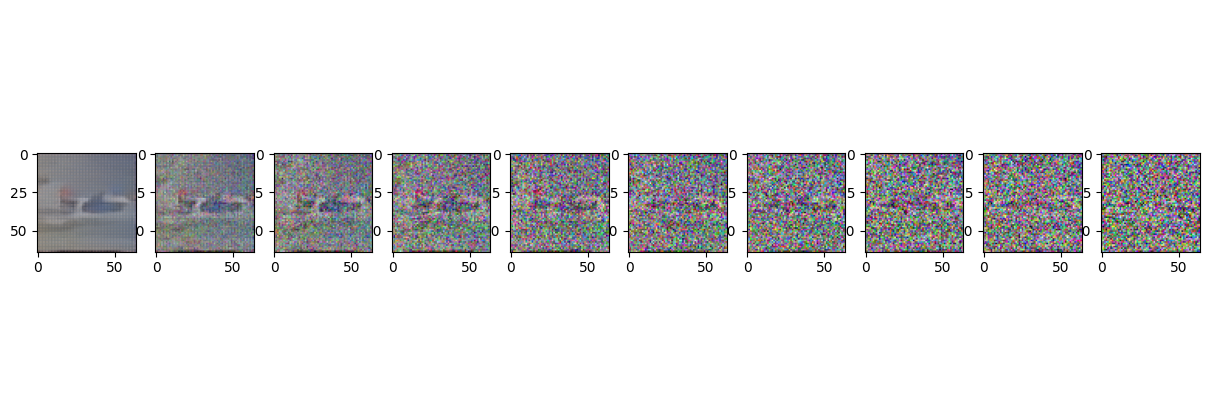

Epoch 20 | step 000 Loss: 0.10696637630462646 


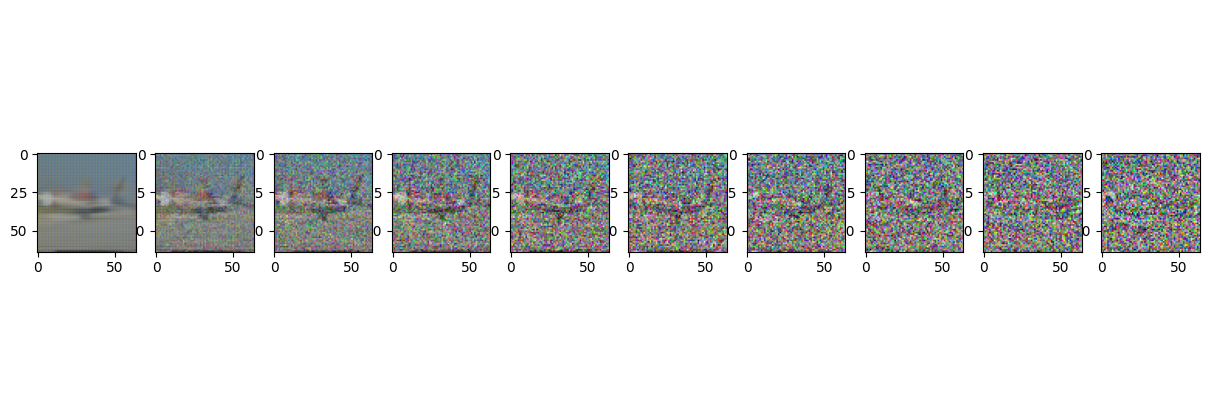

Epoch 30 | step 000 Loss: 0.0868920236825943 


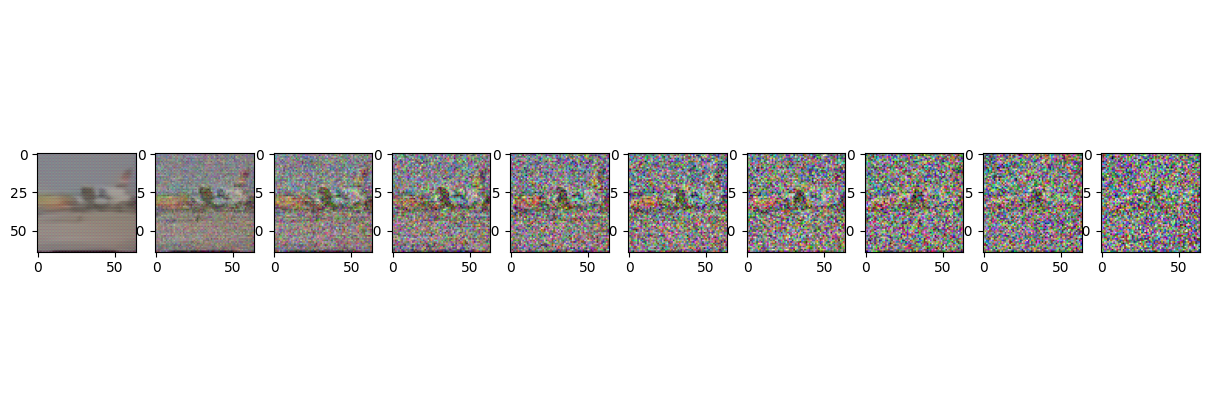

Epoch 40 | step 000 Loss: 0.12025069445371628 


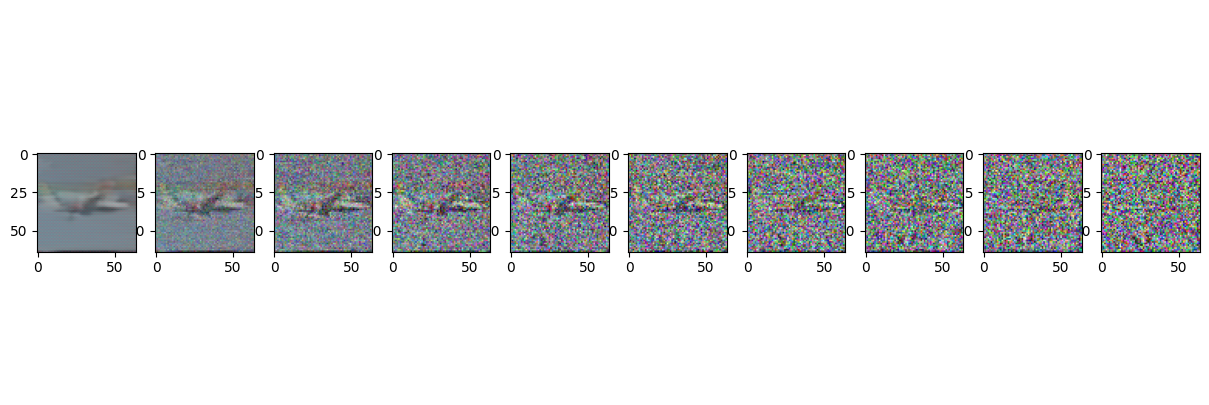

Epoch 50 | step 000 Loss: 0.11338784545660019 


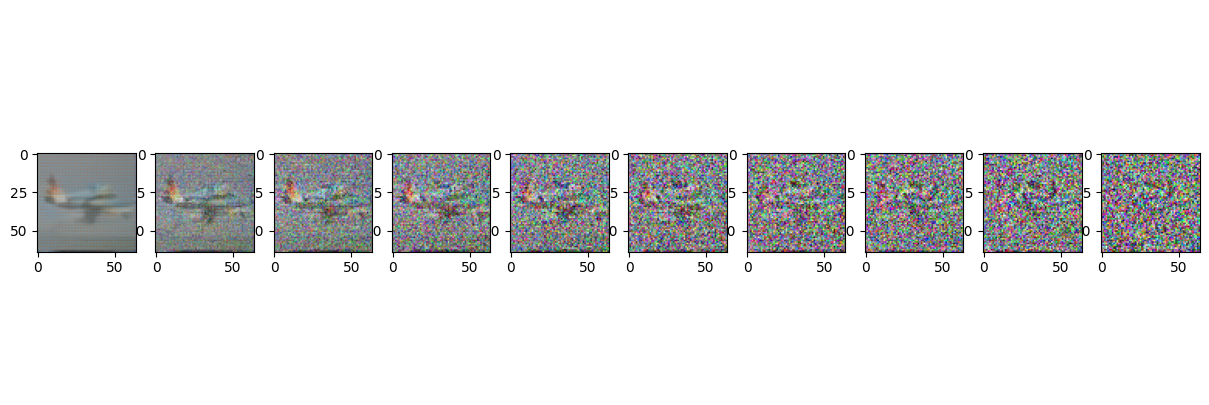

Epoch 60 | step 000 Loss: 0.10482580959796906 


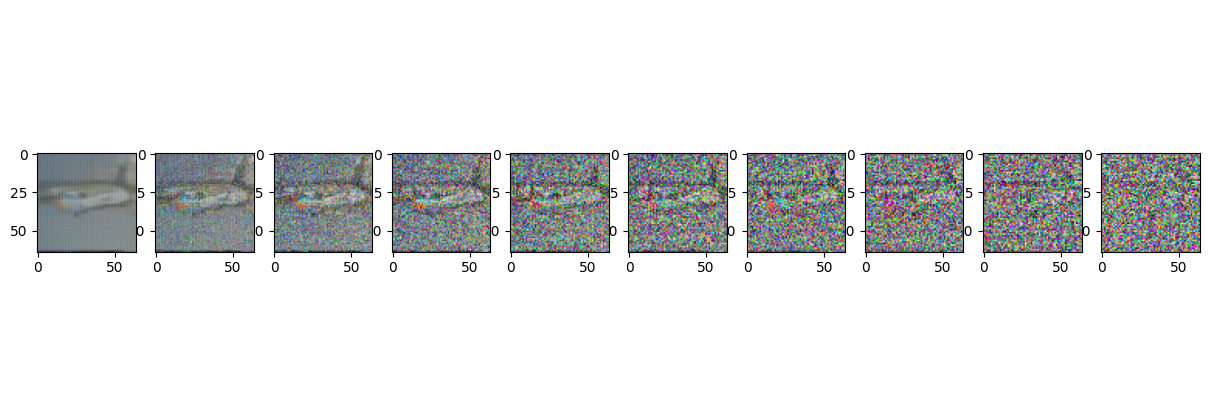

Epoch 70 | step 000 Loss: 0.08095921576023102 


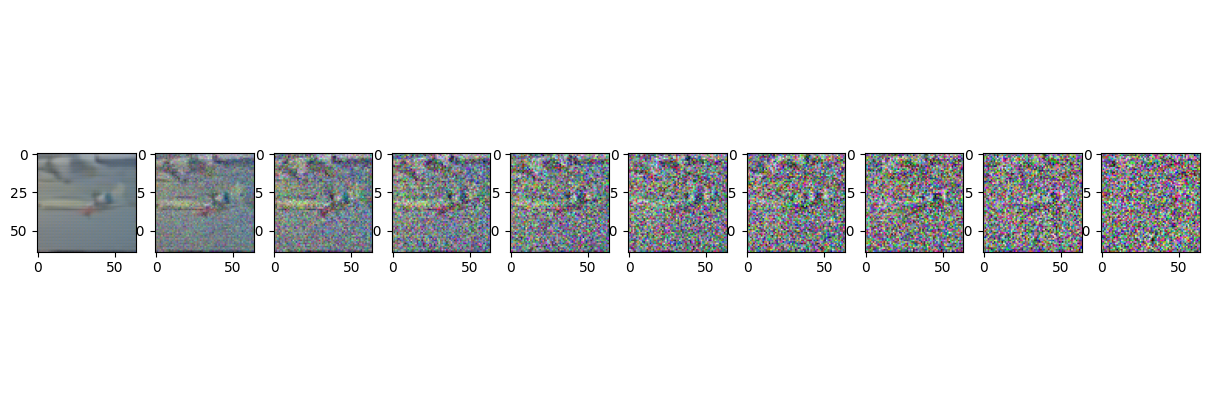

Epoch 80 | step 000 Loss: 0.09731259196996689 


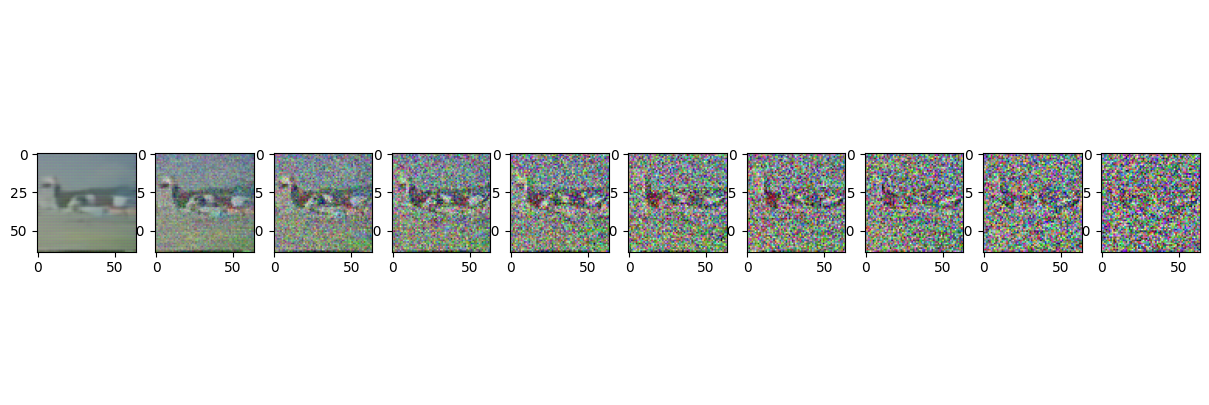

Epoch 90 | step 000 Loss: 0.08846358954906464 


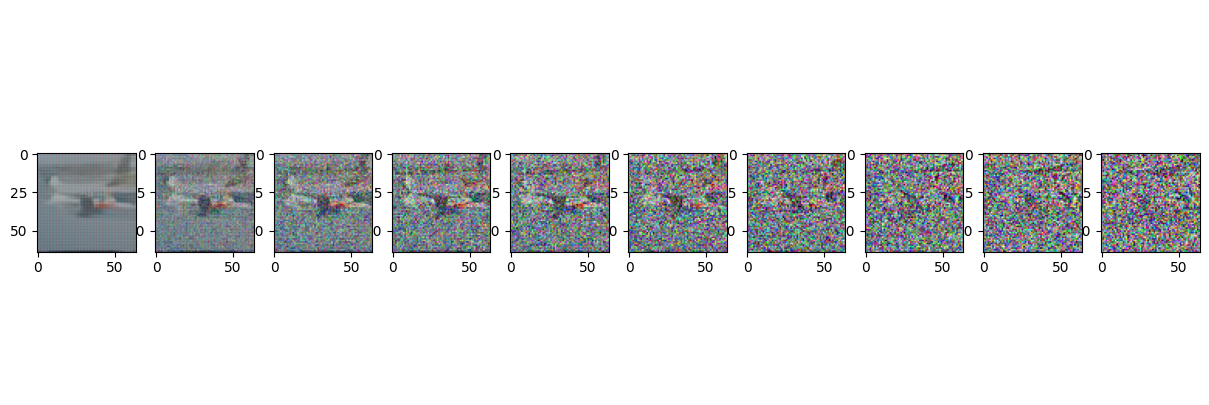

In [30]:
# Model Training. 
BATCH_SIZE = 64
IMG_SIZE = 64
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100 

# Training loop
# For each batch we randonly sample timesteps and add noise to the images.
# In this example the model is trained to predict the noise added to the images (can vary)
# Uss a simple L1 loss function to calculate the loss
# backpropogate the loss and update the model weights as per usual.

# Obviously within this example it is trained to create planes. So it will always create planes....

for epoch in range(epochs):
    #itterates over dataset
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad() #clears the gradients
        actual_batch_size = batch.shape[0]  # Get the actual batch size, in case smaller at end of epoch.
        t = torch.randint(0, T, (actual_batch_size,), device=device).long()
        loss = get_loss(model, batch, t) #computes loss for the current batch
        loss.backward() # gradients
        optimizer.step() # updates the model weights
        
        # prints loss and 
        if epoch % 10 == 0 and step == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            sample_plot_image()